<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual_notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 1
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [58]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [59]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [60]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [61]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [62]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [63]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [64]:
batch_size = 8
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [65]:
model_name = model.__name__
z_dim = 10
label_dim = 1000
gen_inp_dim = z_dim + label_dim
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [66]:
class Gen(nn.Module):
  def __init__(self, inp_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.inp_dim = inp_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.inp_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)
    
    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]

    benign_preds_onehot = arch(inputs)
    benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
    labels = torch.zeros([self.bs, 1000]).cuda()
    for i in range(self.bs):
      random_label = self.randint(0,1000, exclude = benign_preds[i].item())
      labels[i][random_label] = 1.
    
    z = torch.empty(self.bs, 10).cuda()
    labels_and_z = torch.cat((labels, z), dim=1)
    
    z_out = self.forward_z(labels_and_z)
    
    return z_out, None, None, inputs, benign_preds_onehot, labels
  
#    def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
#     for i in range(self.bs):
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z
  
  @staticmethod
  def randint(low, high, exclude):
    temp = np.random.randint(low, high - 1)
    if temp == exclude:
      temp = temp + 1
    return temp
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)


In [67]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
#     print("ap_dist: {}, an_dist: {}".format(ap_dist, an_dist))
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [68]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

# def fool_loss(input, target):
#     true_class = torch.argmax(target, dim=1).view(-1,1).long()
#     return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

def fool_loss_old(input, target, trash):
  print("fool_loss:")
  true_class = torch.argmax(target, dim=1).view(-1,1).long()
  print(true_class)
  print("input: ", input.shape)
  a = input.gather(1, true_class)
  print(a)
  print(1 - a)
  print(torch.mean(1 - a))
  print(torch.log(torch.mean(1-a)))
  print("\n\n")
  # this is wrong! first log should be taken, THEN mean.
  return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))

fool_loss_count = 0

def fool_loss(model_output, target_labels):
  target_labels = target_labels.view(-1, 1).long().cuda()
  target_probabilities = model_output.gather(1, target_labels)
  epsilon = 1e-10
  # highest possible fool_loss is - log(1e-10) == 23
  result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 20 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
  return result

def validation(gen_output, target):
  perturbations, _, _, clean_images, _, _ = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  print("benign preds are: ", benign_preds)
  print("adv preds are: ", adversary_preds)
  print("pert range: ", perturbations.min(), " ", perturbations.max())
  return (benign_preds != adversary_preds).float().mean()


In [69]:
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
#         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    def forward(self, inp, target):
      sigma_B, _, _, X_B, B_Y, labels_onehot = inp

      X_A = X_B + sigma_B
#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

      labels = labels_onehot.argmax(dim=1)
      fooling_loss =  fool_loss(A_Y, labels)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      self.losses = [fooling_loss]
      self.metrics = dict(zip(self.metric_names, [fooling_loss]))

      return sum(self.losses)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [70]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [71]:
env.save_filename = 'resnet50_16'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [76]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(inp_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(inp_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
learn = Learner(data, Gen(inp_dim=gen_inp_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [73]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50_14/resnet50_14_49'
# load_filename = 'vgg16_29/vgg16_29_69'
# load_filename = 'vgg16_12-last'

# learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

In [77]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: resnet50 
	load filename: None 
	save filename: resnet50_16

please MAKE SURE that the config is correct.


In [78]:
#last one was : 754 754
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

learn.fit(50, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])
# learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])


# learn.fit_one_cycle(8, max_lr=5e-01) #mohammad's setting that got 77 validation start on resnet with diversity loss on AdaptiveAvgPool2d
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

epoch,train_loss,valid_loss,validation,fool_loss,time
0,21.498146,21.403860,0.999000,21.403854,05:09
1,21.509029,21.542772,0.999000,21.542774,05:06
2,21.487804,21.501215,0.999000,21.501213,05:07
3,21.580107,21.384775,0.999000,21.384779,05:06
4,21.447987,21.581182,0.999000,21.581175,05:07
5,21.450933,21.463638,0.999000,21.463638,05:08
6,21.483891,21.477240,0.999000,21.477243,05:10
7,21.554678,21.677723,0.999000,21.677723,05:08
8,21.550678,21.446928,0.999000,21.446924,05:52
9,21.536503,21.558086,0.999000,21.558086,06:15


target probs tensor([[1.9832e-08],
        [2.5097e-14],
        [3.8241e-15],
        [9.9577e-11],
        [6.5932e-15],
        [2.5900e-10],
        [7.4395e-14],
        [5.3394e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.886852264404297: 
target probs tensor([[4.3031e-17],
        [3.2738e-15],
        [1.6157e-11],
        [2.8072e-06],
        [6.6925e-13],
        [1.7323e-17],
        [2.0375e-10],
        [1.7739e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.58489227294922: 
target probs tensor([[8.2174e-05],
        [2.6428e-12],
        [7.5195e-15],
        [1.0150e-11],
        [1.2810e-11],
        [3.4034e-16],
        [2.1169e-12],
        [5.9530e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.048015594482422: 
target probs tensor([[2.8317e-12],
        [2.2655e-14],
        [5.7071e-16],
        [3.8665e-15],
        [2.2596e-11],
        [4.3600e-14],
        [3.3912e-10],
        [2.8199e-12]], device='cuda:0', grad_fn=<Ga

target probs tensor([[8.5737e-17],
        [7.1814e-15],
        [1.9901e-10],
        [3.2316e-11],
        [1.2955e-18],
        [3.9521e-16],
        [2.5097e-14],
        [2.6336e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.581554412841797: 
target probs tensor([[6.6165e-12],
        [2.2960e-14],
        [4.1159e-06],
        [9.3800e-14],
        [1.2234e-09],
        [1.2842e-16],
        [3.6820e-13],
        [1.2904e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.366222381591797: 
target probs tensor([[2.7296e-13],
        [3.5322e-15],
        [1.8085e-14],
        [6.6755e-11],
        [2.1617e-19],
        [5.3123e-14],
        [5.3400e-12],
        [4.8851e-17]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.954994201660156: 
target probs tensor([[2.4206e-14],
        [1.0106e-14],
        [3.3912e-10],
        [5.6077e-16],
        [4.1757e-10],
        [2.4089e-17],
        [5.3399e-10],
        [1.0797e-09]], device='cuda:0', grad_fn=<G

benign preds are:  tensor([404, 325, 522, 598, 112, 128, 508, 983], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[1.5256e-11],
        [2.3488e-12],
        [9.4991e-14],
        [1.9936e-17],
        [1.1462e-15],
        [9.1247e-15],
        [2.3976e-07],
        [8.1603e-10]], device='cuda:0'), loss: 21.75537872314453: 
benign preds are:  tensor([967, 873, 293, 728, 796, 739, 472, 571], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([204, 923, 904, 336, 555, 590, 218, 410], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([409, 283, 361, 157,

benign preds are:  tensor([562, 242, 824, 255, 752, 408, 180, 336], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([801,  12, 493, 188, 690, 917, 993, 379], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([456, 844, 480, 270, 217,  97, 291, 229], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([872,  48, 333, 621, 784, 318, 756, 117], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([924, 279, 561

benign preds are:  tensor([113, 948, 283, 954, 711, 700,  62,  90], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([331, 721, 459, 163, 536, 554, 407, 974], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([401, 637, 458, 641, 831, 440, 475, 573], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([300, 558, 124,  41, 628, 102, 701, 380], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([268, 541,  77

benign preds are:  tensor([599,  59, 497, 826, 492, 574, 874,  10], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[1.3504e-08],
        [1.2692e-09],
        [1.4716e-14],
        [2.5249e-14],
        [5.0232e-13],
        [7.5468e-05],
        [1.7200e-16],
        [1.8274e-07]], device='cuda:0'), loss: 19.453304290771484: 
benign preds are:  tensor([235,  61, 614, 909, 611, 552, 763, 780], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([498, 583, 640, 422, 155,  93, 586, 621], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([704, 762, 172, 305

target probs tensor([[3.5586e-16],
        [2.5024e-17],
        [3.8241e-15],
        [1.1716e-12],
        [6.4587e-08],
        [1.1127e-15],
        [5.1006e-10],
        [9.0613e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.978477478027344: 
target probs tensor([[2.1683e-12],
        [3.4034e-16],
        [7.8827e-16],
        [2.8830e-15],
        [1.2465e-14],
        [5.7604e-05],
        [3.9105e-07],
        [7.3718e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.06558609008789: 
target probs tensor([[9.3430e-13],
        [1.0876e-13],
        [4.1757e-10],
        [3.4175e-03],
        [8.2540e-09],
        [5.4268e-15],
        [1.1272e-12],
        [3.2285e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 19.373573303222656: 
target probs tensor([[1.3823e-15],
        [6.6165e-12],
        [4.3907e-09],
        [5.3399e-10],
        [5.5724e-21],
        [1.4572e-12],
        [4.8030e-03],
        [1.6562e-07]], device='cuda:0', grad_fn=<Ga

target probs tensor([[1.2810e-11],
        [4.4376e-13],
        [2.8923e-17],
        [4.0817e-12],
        [2.2968e-15],
        [5.9589e-14],
        [2.4834e-12],
        [1.0357e-13]], device='cuda:0', grad_fn=<GatherBackward>), loss: 23.001956939697266: 
target probs tensor([[7.6701e-12],
        [5.0743e-02],
        [3.5815e-08],
        [9.2518e-13],
        [2.8609e-15],
        [4.3727e-16],
        [1.0357e-13],
        [9.7950e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 19.77423858642578: 
target probs tensor([[3.8665e-15],
        [9.7950e-15],
        [2.2322e-11],
        [5.5769e-09],
        [5.4528e-16],
        [6.6165e-12],
        [8.3569e-16],
        [2.1457e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.81610107421875: 
target probs tensor([[9.4642e-15],
        [7.9939e-15],
        [4.6139e-10],
        [1.4421e-14],
        [5.5769e-09],
        [7.1871e-13],
        [3.2699e-13],
        [6.3996e-17]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([208, 906, 963, 779,   0, 662, 901, 426], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([791, 591, 788, 786, 203, 524, 918,  22], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([221, 347, 959, 349, 365, 680, 446, 108], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([627, 334, 881, 264, 454, 716,   6, 202], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([113, 232, 818

benign preds are:  tensor([734, 778, 175, 547, 137, 189, 310, 500], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([187, 633,  32, 683, 319, 228, 899, 451], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[2.5464e-13],
        [8.2540e-09],
        [4.6729e-15],
        [2.4176e-13],
        [6.5244e-14],
        [1.9763e-09],
        [5.6077e-16],
        [1.1815e-15]], device='cuda:0'), loss: 22.092830657958984: 
benign preds are:  tensor([874, 253, 946, 209, 878,   2, 925, 186], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([746,  94, 487,  31

benign preds are:  tensor([988, 581, 399, 543, 200,  16, 375, 867], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([207, 639, 702, 621, 170,  45, 939, 929], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([460, 110, 715, 189, 976, 671, 353, 986], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([526,  25, 243, 132, 235, 698, 518,  86], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([748, 372, 532

benign preds are:  tensor([367,  16,  50, 620, 751, 233,  13, 450], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[7.5729e-16],
        [4.8145e-13],
        [4.4765e-14],
        [2.2180e-16],
        [1.0192e-15],
        [6.6274e-15],
        [3.2607e-12],
        [3.9284e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.979755401611328: 
target probs tensor([[8.0602e-16],
        [2.0040e-10],
        [3.7090e-06],
        [7.8234e-16],
        [3.2018e-12],
        [1.3416e-13],
        [7.1871e-13],
        [4.7541e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.51959800720215: 
target probs tensor([[6.3112e-12],
        [8.2174e-05],
        [2.8498e-14],
        [1.0598e-15],
        [4.9288e-10],
        [9.2961e-13],
        [5.7069e-14],
        [2.5036e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss:

target probs tensor([[1.7354e-11],
        [2.3470e-07],
        [2.9274e-05],
        [2.1529e-16],
        [5.3383e-12],
        [8.6562e-13],
        [1.2131e-09],
        [4.1927e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.12771224975586: 
target probs tensor([[8.0153e-13],
        [9.7564e-19],
        [5.0154e-10],
        [1.3562e-17],
        [1.5680e-15],
        [1.0797e-09],
        [1.9968e-14],
        [2.5900e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.332290649414062: 
target probs tensor([[6.6925e-13],
        [7.4158e-07],
        [7.5729e-16],
        [1.8102e-13],
        [1.9919e-10],
        [2.2493e-12],
        [1.9210e-08],
        [3.9416e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.10834503173828: 
target probs tensor([[4.0636e-11],
        [8.1603e-10],
        [2.4176e-13],
        [2.6161e-12],
        [5.1847e-09],
        [1.1127e-15],
        [2.4583e-16],
        [3.4175e-03]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([ 68, 900, 501, 903, 827, 732, 766, 916], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 36, 439, 497, 795, 473, 690, 250, 821], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([404, 325, 522, 598, 112, 128, 508, 983], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[8.4166e-12],
        [3.8516e-16],
        [4.5051e-12],
        [4.7541e-11],
        [4.4376e-13],
        [1.2810e-11],
        [3.9262e-07],
        [2.0040e-10]], device='cuda:0'), loss: 21.774051666259766: 
benign preds are:  tensor([967, 873, 293, 728

benign preds are:  tensor([547, 853, 724, 400, 443, 249, 512, 978], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([286, 158, 823, 832, 357, 373, 449, 572], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([562, 242, 824, 255, 752, 408, 180, 336], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([801,  12, 493, 188, 690, 917, 993, 379], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([456, 844, 480

benign preds are:  tensor([565, 569,  53, 755, 503, 580, 298, 358], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([642, 795,  98, 821, 597, 694, 895, 434], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([113, 948, 283, 954, 711, 700,  62,  90], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([331, 721, 459, 163, 536, 554, 407, 974], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([401, 637, 458

benign preds are:  tensor([ 72, 508, 417, 332, 747, 578, 210, 271], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([762, 435, 490, 761, 808,  68, 307,  88], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([599,  59, 497, 826, 492, 574, 874,  10], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[4.0817e-12],
        [2.4342e-15],
        [7.5326e-08],
        [1.4097e-13],
        [6.6012e-12],
        [9.0994e-14],
        [7.9198e-15],
        [5.1242e-14]], device='cuda:0'), loss: 22.184276580810547: 
benign preds are:  tensor([235,  61, 614, 909

target probs tensor([[6.1383e-16],
        [1.5319e-13],
        [3.1510e-13],
        [3.6803e-11],
        [7.9939e-15],
        [2.3732e-18],
        [1.3905e-12],
        [4.4858e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.938034057617188: 
target probs tensor([[7.4158e-07],
        [1.6970e-15],
        [1.8274e-07],
        [2.4176e-13],
        [9.9577e-11],
        [2.9117e-11],
        [1.8010e-12],
        [1.2348e-18]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.852155685424805: 
target probs tensor([[1.8102e-13],
        [4.5160e-12],
        [3.9521e-16],
        [1.3122e-07],
        [1.9149e-12],
        [2.5036e-14],
        [5.5516e-14],
        [1.4373e-18]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.120105743408203: 
target probs tensor([[3.8573e-10],
        [2.6469e-07],
        [2.5179e-12],
        [1.1614e-12],
        [1.3777e-09],
        [1.5720e-15],
        [2.6734e-18],
        [6.3011e-15]], device='cuda:0', grad_fn=<G

target probs tensor([[2.6619e-15],
        [1.3984e-13],
        [8.9916e-14],
        [5.5769e-09],
        [2.5027e-14],
        [1.0357e-13],
        [2.4641e-11],
        [1.9149e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.49062156677246: 
target probs tensor([[6.8942e-16],
        [8.5741e-11],
        [2.5583e-16],
        [1.1523e-17],
        [1.1471e-05],
        [9.8947e-08],
        [2.5320e-12],
        [1.4965e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 19.712844848632812: 
target probs tensor([[1.7386e-09],
        [2.4662e-11],
        [3.2633e-10],
        [4.8970e-16],
        [3.5586e-16],
        [6.3972e-14],
        [2.2145e-18],
        [4.8030e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.242095947265625: 
target probs tensor([[2.4423e-11],
        [6.9289e-15],
        [2.0443e-10],
        [6.8582e-08],
        [2.6197e-16],
        [8.6892e-09],
        [1.5116e-07],
        [1.7229e-11]], device='cuda:0', grad_fn=<Ga

benign preds are:  tensor([ 26, 858, 710, 183, 782, 153, 440, 592], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([603, 589, 819, 395, 968, 388, 679, 865], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([208, 906, 963, 779,   0, 662, 901, 426], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([791, 591, 788, 786, 203, 524, 918,  22], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([221, 347, 959

benign preds are:  tensor([ 69, 390, 470, 755, 897, 350,  21, 491], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([234, 174, 965, 352, 979, 538,  92,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([734, 778, 175, 547, 137, 189, 310, 500], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([187, 633,  32, 683, 319, 228, 899, 451], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[8.5069e-16],
     

benign preds are:  tensor([953, 594, 541,  27,  39, 317, 492, 107], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([236, 126, 989, 625, 593, 131, 119, 647], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([988, 581, 399, 543, 200,  16, 375, 867], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([207, 639, 702, 621, 170,  45, 939, 929], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([460, 110, 715

benign preds are:  tensor([196, 194, 335, 547, 855, 805, 420,  49], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 79, 949, 912, 184, 199, 799, 977, 321], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([367,  16,  50, 620, 751, 233,  13, 450], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[1.0656e-15],
        [1.1526e-14],
        [5.7069e-14],
        [9.3800e-14],
        [1.2112e-15],
        [2.0409e-13],
        [3.1724e-17],
        [2.8485e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.74324607849121: 
target probs tensor(

target probs tensor([[1.7323e-17],
        [2.7150e-18],
        [2.5900e-10],
        [6.3011e-15],
        [2.0375e-10],
        [1.3978e-15],
        [2.3470e-07],
        [5.7911e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.75702476501465: 
target probs tensor([[1.4746e-13],
        [3.3815e-13],
        [2.7985e-13],
        [8.3569e-16],
        [6.6925e-13],
        [6.8942e-16],
        [9.4407e-16],
        [4.3484e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.978925704956055: 
target probs tensor([[7.5572e-15],
        [1.1205e-13],
        [6.5244e-14],
        [1.3170e-16],
        [4.5160e-12],
        [8.5373e-10],
        [1.1599e-16],
        [1.1122e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.644729614257812: 
target probs tensor([[6.5244e-14],
        [2.5752e-12],
        [9.8947e-08],
        [2.8341e-10],
        [1.0347e-12],
        [1.1716e-12],
        [1.0797e-09],
        [2.1059e-10]], device='cuda:0', grad_fn=<Ga

benign preds are:  tensor([278, 758, 323, 771,  99, 463,  78, 378], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([142, 484, 304, 182, 527, 671, 731, 777], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 68, 900, 501, 903, 827, 732, 766, 916], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 36, 439, 497, 795, 473, 690, 250, 821], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([404, 325, 522

benign preds are:  tensor([730, 511, 448, 544, 725, 797, 247, 169], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([141, 814, 114,   5,  37, 533, 668, 821], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([547, 853, 724, 400, 443, 249, 512, 978], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([286, 158, 823, 832, 357, 373, 449, 572], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([562, 242, 824

benign preds are:  tensor([252, 528, 636, 118, 405, 618, 377, 658], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([723, 435, 682, 329, 718, 507, 384, 173], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([565, 569,  53, 755, 503, 580, 298, 358], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([642, 795,  98, 821, 597, 694, 895, 434], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([113, 948, 283

benign preds are:  tensor([274, 531, 402, 197, 176, 477, 887, 760], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([702, 865, 515, 996, 928, 269, 847, 579], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 508, 417, 332, 747, 578, 210, 271], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([762, 435, 490, 761, 808,  68, 307,  88], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([599,  59, 497

target probs tensor([[3.1569e-14],
        [1.1187e-06],
        [2.3026e-14],
        [8.3410e-16],
        [1.2929e-19],
        [3.1072e-16],
        [9.8947e-08],
        [2.4643e-13]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.997875213623047: 
target probs tensor([[7.5302e-12],
        [2.5179e-12],
        [2.0380e-16],
        [2.1457e-14],
        [1.2465e-14],
        [3.9899e-15],
        [7.6519e-12],
        [7.6519e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.99518585205078: 
target probs tensor([[4.4376e-13],
        [1.8561e-12],
        [1.8010e-12],
        [1.2842e-16],
        [1.6172e-08],
        [3.8623e-12],
        [2.2337e-10],
        [6.5244e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.232738494873047: 
target probs tensor([[4.5231e-12],
        [3.9262e-07],
        [4.6174e-18],
        [6.3996e-17],
        [4.4678e-13],
        [2.1617e-19],
        [4.4748e-14],
        [2.5726e-14]], device='cuda:0', grad_fn=<Ga

target probs tensor([[5.3399e-10],
        [1.6631e-16],
        [8.1702e-13],
        [1.1882e-11],
        [9.6275e-11],
        [1.0702e-17],
        [1.5276e-16],
        [6.6661e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.695566177368164: 
target probs tensor([[1.3562e-17],
        [4.7219e-13],
        [7.7429e-12],
        [2.4176e-13],
        [4.9950e-10],
        [2.2617e-11],
        [6.1072e-16],
        [5.6758e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.39796257019043: 
target probs tensor([[2.3026e-14],
        [2.5583e-16],
        [4.4376e-13],
        [5.5220e-16],
        [8.7908e-12],
        [2.3092e-07],
        [5.3399e-10],
        [7.5599e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.987075805664062: 
target probs tensor([[3.6705e-12],
        [1.2245e-09],
        [4.8524e-06],
        [1.3496e-03],
        [4.1780e-07],
        [4.9370e-08],
        [2.9052e-11],
        [5.9034e-15]], device='cuda:0', grad_fn=<Ga

benign preds are:  tensor([ 72, 862, 747,   4, 990, 444, 178, 994], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 26, 858, 710, 183, 782, 153, 440, 592], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([603, 589, 819, 395, 968, 388, 679, 865], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([208, 906, 963, 779,   0, 662, 901, 426], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([791, 591, 788

benign preds are:  tensor([  8, 499, 804,  44, 336, 641,  85, 441], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 69, 390, 470, 755, 897, 350,  21, 491], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([234, 174, 965, 352, 979, 538,  92,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([734, 778, 175, 547, 137, 189, 310, 500], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([187, 633,  32

benign preds are:  tensor([302, 193, 891, 488, 442, 160,  19, 190], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([953, 594, 541,  27,  39, 317, 492, 107], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([236, 126, 989, 625, 593, 131, 119, 647], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([988, 581, 399, 543, 200,  16, 375, 867], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([207, 639, 702

benign preds are:  tensor([934, 545, 534, 416, 368, 870, 844,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([196, 194, 335, 547, 855, 805, 420,  49], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 79, 949, 912, 184, 199, 799, 977, 321], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([367,  16,  50, 620, 751, 233,  13, 450], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[2.0893e-13],
     

target probs tensor([[4.8524e-06],
        [1.9149e-12],
        [8.5636e-17],
        [4.6729e-15],
        [6.2384e-17],
        [9.9577e-11],
        [5.9530e-10],
        [1.1462e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.34596824645996: 
target probs tensor([[4.1757e-10],
        [2.0443e-10],
        [1.9853e-16],
        [2.1816e-15],
        [4.3907e-09],
        [1.0539e-14],
        [6.2004e-15],
        [1.5723e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.20364761352539: 
target probs tensor([[6.8880e-07],
        [2.5987e-15],
        [1.9559e-13],
        [2.1726e-19],
        [1.1338e-13],
        [1.2771e-17],
        [9.4407e-16],
        [7.7807e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.920738220214844: 
target probs tensor([[2.0483e-17],
        [3.9416e-12],
        [3.8524e-09],
        [9.3430e-13],
        [8.2540e-09],
        [1.1526e-14],
        [8.5286e-10],
        [7.4923e-13]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([125, 973, 841, 106, 892, 237, 772, 521], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([278, 758, 323, 771,  99, 463,  78, 378], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([142, 484, 304, 182, 527, 671, 731, 777], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 68, 900, 501, 903, 827, 732, 766, 916], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 36, 439, 497

benign preds are:  tensor([101, 825, 288, 669, 611, 972, 696, 803], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([730, 511, 448, 544, 725, 797, 247, 169], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([141, 814, 114,   5,  37, 533, 668, 821], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([547, 853, 724, 400, 443, 249, 512, 978], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([286, 158, 823

benign preds are:  tensor([890, 216, 312, 391, 560, 774, 496, 281], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([252, 528, 636, 118, 405, 618, 377, 658], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([723, 435, 682, 329, 718, 507, 384, 173], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([565, 569,  53, 755, 503, 580, 298, 358], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([642, 795,  98

benign preds are:  tensor([742, 720, 205, 629, 520, 297, 956, 769], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([274, 531, 402, 197, 176, 477, 887, 760], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([702, 865, 515, 996, 928, 269, 847, 579], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 508, 417, 332, 747, 578, 210, 271], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([762, 435, 490

target probs tensor([[4.5231e-12],
        [1.1168e-01],
        [6.0377e-16],
        [8.0602e-16],
        [1.5371e-07],
        [1.5542e-14],
        [2.3470e-07],
        [2.6977e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 18.528594970703125: 
target probs tensor([[2.5036e-14],
        [2.5583e-16],
        [2.4345e-13],
        [7.3264e-10],
        [2.2655e-14],
        [1.8069e-12],
        [5.0631e-14],
        [2.8609e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.75825309753418: 
target probs tensor([[3.4870e-09],
        [4.7340e-09],
        [1.0494e-16],
        [1.0876e-13],
        [1.2904e-14],
        [8.6892e-09],
        [1.1519e-11],
        [2.0548e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.517745971679688: 
target probs tensor([[3.8241e-15],
        [1.1076e-18],
        [3.1194e-17],
        [7.5729e-16],
        [1.0150e-11],
        [6.4384e-10],
        [6.5549e-15],
        [1.5723e-12]], device='cuda:0', grad_fn=<Ga

target probs tensor([[1.2811e-08],
        [1.6568e-07],
        [2.2381e-13],
        [2.4938e-14],
        [9.2518e-13],
        [2.1524e-12],
        [1.2215e-15],
        [6.5952e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.487485885620117: 
target probs tensor([[5.4969e-13],
        [2.6977e-14],
        [7.5905e-16],
        [8.9931e-07],
        [6.4583e-14],
        [1.7399e-12],
        [1.4239e-12],
        [8.4407e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.806591033935547: 
target probs tensor([[3.2033e-11],
        [1.1127e-15],
        [2.1946e-18],
        [6.1150e-10],
        [2.5987e-15],
        [3.9262e-07],
        [3.5815e-08],
        [5.5516e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.9758358001709: 
target probs tensor([[2.1764e-14],
        [1.4432e-13],
        [3.3984e-14],
        [1.6870e-14],
        [4.8919e-13],
        [9.0563e-09],
        [3.6705e-12],
        [4.0636e-11]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([674, 942, 960, 817, 676, 256, 714, 382], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 862, 747,   4, 990, 444, 178, 994], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 26, 858, 710, 183, 782, 153, 440, 592], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([603, 589, 819, 395, 968, 388, 679, 865], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([208, 906, 963

benign preds are:  tensor([424,  60, 149, 344, 722,  46, 753, 894], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([  8, 499, 804,  44, 336, 641,  85, 441], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 69, 390, 470, 755, 897, 350,  21, 491], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([234, 174, 965, 352, 979, 538,  92,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([734, 778, 175

benign preds are:  tensor([688, 229, 489, 337, 943, 262, 634,  18], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([302, 193, 891, 488, 442, 160,  19, 190], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([953, 594, 541,  27,  39, 317, 492, 107], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([236, 126, 989, 625, 593, 131, 119, 647], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([988, 581, 399

benign preds are:  tensor([ 42,  46, 216, 854, 595, 931, 147, 110], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([934, 545, 534, 416, 368, 870, 844,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([196, 194, 335, 547, 855, 805, 420,  49], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 79, 949, 912, 184, 199, 799, 977, 321], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([367,  16,  50

target probs tensor([[1.3691e-08],
        [1.7323e-17],
        [1.5680e-15],
        [1.1338e-13],
        [1.3249e-09],
        [4.6729e-15],
        [3.5467e-16],
        [1.3771e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.076080322265625: 
target probs tensor([[2.6197e-13],
        [2.3809e-11],
        [2.2824e-11],
        [1.9129e-17],
        [8.8118e-11],
        [4.9288e-10],
        [3.9416e-12],
        [7.7807e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.66682243347168: 
target probs tensor([[3.9105e-07],
        [2.1169e-12],
        [2.2412e-17],
        [2.3520e-11],
        [1.5239e-10],
        [7.9098e-10],
        [3.2633e-10],
        [1.8085e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.39246940612793: 
target probs tensor([[8.6892e-09],
        [3.0106e-07],
        [4.6278e-16],
        [2.0375e-10],
        [3.5657e-07],
        [1.7354e-11],
        [1.4731e-13],
        [8.0673e-09]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([164,  57, 991, 292, 143, 815, 672, 507], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([125, 973, 841, 106, 892, 237, 772, 521], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([278, 758, 323, 771,  99, 463,  78, 378], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([142, 484, 304, 182, 527, 671, 731, 777], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 68, 900, 501

benign preds are:  tensor([860, 913, 341, 238, 552, 832, 871, 458], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([101, 825, 288, 669, 611, 972, 696, 803], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([730, 511, 448, 544, 725, 797, 247, 169], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([141, 814, 114,   5,  37, 533, 668, 821], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([547, 853, 724

target probs tensor([[6.6661e-14],
        [1.1338e-13],
        [6.5244e-14],
        [2.7296e-13],
        [5.7071e-16],
        [1.6172e-08],
        [2.1946e-18],
        [2.2606e-12]], device='cuda:0'), loss: 22.385902404785156: 
benign preds are:  tensor([890, 216, 312, 391, 560, 774, 496, 281], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([252, 528, 636, 118, 405, 618, 377, 658], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([723, 435, 682, 329, 718, 507, 384, 173], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([565, 569,  53, 755

benign preds are:  tensor([651, 898,  63, 742, 123, 895, 951, 686], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([742, 720, 205, 629, 520, 297, 956, 769], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([274, 531, 402, 197, 176, 477, 887, 760], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([702, 865, 515, 996, 928, 269, 847, 579], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 508, 417

target probs tensor([[1.5720e-15],
        [8.6562e-13],
        [1.2672e-12],
        [2.4002e-10],
        [7.6701e-12],
        [1.7030e-06],
        [5.3123e-14],
        [4.6278e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.64306640625: 
target probs tensor([[2.1816e-15],
        [1.5371e-07],
        [2.8635e-15],
        [1.9210e-08],
        [2.9052e-11],
        [8.2174e-05],
        [1.6157e-12],
        [2.3809e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 19.68767547607422: 
target probs tensor([[5.4268e-15],
        [1.6145e-10],
        [5.5615e-12],
        [3.4383e-16],
        [4.2965e-14],
        [1.1615e-15],
        [1.6865e-13],
        [4.1927e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.893545150756836: 
target probs tensor([[3.4034e-16],
        [1.2245e-09],
        [4.3551e-16],
        [4.0338e-12],
        [2.8341e-10],
        [8.0153e-13],
        [1.6970e-15],
        [3.4834e-07]], device='cuda:0', grad_fn=<Gather

target probs tensor([[1.4714e-15],
        [2.9561e-13],
        [5.4651e-11],
        [3.8630e-10],
        [8.5636e-17],
        [9.8167e-11],
        [2.1764e-14],
        [1.2811e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.080169677734375: 
target probs tensor([[6.3011e-15],
        [1.2904e-14],
        [2.1529e-16],
        [2.4999e-16],
        [1.8010e-12],
        [6.2063e-16],
        [1.4492e-13],
        [1.0864e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 23.023414611816406: 
target probs tensor([[3.2033e-11],
        [3.2079e-05],
        [1.0046e-12],
        [6.0546e-09],
        [5.3400e-12],
        [4.0636e-11],
        [8.1702e-13],
        [4.5231e-12]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.834400177001953: 
target probs tensor([[4.6123e-14],
        [1.7019e-14],
        [2.3481e-11],
        [9.1247e-15],
        [1.0046e-12],
        [1.0585e-14],
        [4.1607e-12],
        [3.2633e-10]], device='cuda:0', grad_fn=<G

target probs tensor([[8.6321e-09],
        [3.0883e-14],
        [5.3400e-12],
        [5.1006e-10],
        [2.2617e-11],
        [1.6549e-10],
        [9.9577e-11],
        [4.2098e-09]], device='cuda:0'), loss: 21.530208587646484: 
benign preds are:  tensor([674, 942, 960, 817, 676, 256, 714, 382], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 862, 747,   4, 990, 444, 178, 994], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 26, 858, 710, 183, 782, 153, 440, 592], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([603, 589, 819, 395

benign preds are:  tensor([ 38, 432, 971, 787, 606,  73, 139, 548], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([424,  60, 149, 344, 722,  46, 753, 894], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([  8, 499, 804,  44, 336, 641,  85, 441], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 69, 390, 470, 755, 897, 350,  21, 491], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([234, 174, 965

benign preds are:  tensor([564, 513, 104, 577, 758, 510, 848, 922], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([688, 229, 489, 337, 943, 262, 634,  18], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([302, 193, 891, 488, 442, 160,  19, 190], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([953, 594, 541,  27,  39, 317, 492, 107], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([236, 126, 989

target probs tensor([[1.1732e-09],
        [4.7219e-13],
        [2.6734e-18],
        [2.1820e-10],
        [6.4092e-14],
        [1.7706e-12],
        [4.8970e-16],
        [4.1656e-08]], device='cuda:0'), loss: 21.805984497070312: 
benign preds are:  tensor([ 42,  46, 216, 854, 595, 931, 147, 110], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([934, 545, 534, 416, 368, 870, 844,  38], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([196, 194, 335, 547, 855, 805, 420,  49], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 79, 949, 912, 184

target probs tensor([[1.4752e-08],
        [4.2083e-11],
        [2.0375e-10],
        [2.3717e-06],
        [1.6865e-13],
        [1.5319e-13],
        [1.1815e-15],
        [8.6892e-09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 20.39881134033203: 
target probs tensor([[1.5680e-15],
        [1.5716e-10],
        [1.9968e-14],
        [2.3657e-10],
        [4.9370e-08],
        [2.1559e-08],
        [2.9561e-13],
        [8.5767e-15]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.30792999267578: 
target probs tensor([[1.5631e-11],
        [3.4383e-16],
        [4.7897e-17],
        [7.4647e-16],
        [3.8516e-16],
        [2.2322e-11],
        [2.2338e-09],
        [1.2782e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.573711395263672: 
target probs tensor([[1.3061e-14],
        [1.0901e-14],
        [1.7386e-09],
        [1.8057e-12],
        [3.5954e-13],
        [2.4889e-11],
        [5.2896e-13],
        [1.9289e-14]], device='cuda:0', grad_fn=<Gat

benign preds are:  tensor([ 50,  93, 258, 888, 689, 687, 154, 134], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([164,  57, 991, 292, 143, 815, 672, 507], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([125, 973, 841, 106, 892, 237, 772, 521], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([278, 758, 323, 771,  99, 463,  78, 378], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([142, 484, 304

benign preds are:  tensor([950, 198, 211, 616, 466, 920,  70, 231], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([860, 913, 341, 238, 552, 832, 871, 458], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([101, 825, 288, 669, 611, 972, 696, 803], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([730, 511, 448, 544, 725, 797, 247, 169], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([141, 814, 114

benign preds are:  tensor([338, 907, 622, 848, 558, 376, 605, 619], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[1.6157e-12],
        [1.3249e-09],
        [6.1746e-10],
        [8.0673e-09],
        [4.7208e-15],
        [3.3306e-14],
        [2.8839e-17],
        [2.8341e-10]], device='cuda:0'), loss: 21.72706413269043: 
benign preds are:  tensor([890, 216, 312, 391, 560, 774, 496, 281], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([252, 528, 636, 118, 405, 618, 377, 658], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([723, 435, 682, 329,

benign preds are:  tensor([960, 472, 962, 638, 406, 992, 875, 516], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([651, 898,  63, 742, 123, 895, 951, 686], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([742, 720, 205, 629, 520, 297, 956, 769], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([274, 531, 402, 197, 176, 477, 887, 760], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([702, 865, 515

target probs tensor([[4.2094e-14],
        [1.7899e-11],
        [4.7219e-13],
        [1.0192e-15],
        [4.5051e-12],
        [1.3339e-06],
        [1.0494e-16],
        [8.5015e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.530372619628906: 
target probs tensor([[3.3070e-14],
        [4.8524e-06],
        [7.2874e-15],
        [9.4642e-15],
        [8.6321e-09],
        [9.6486e-11],
        [5.3753e-16],
        [1.8946e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.03390884399414: 
target probs tensor([[2.1169e-12],
        [2.8317e-12],
        [5.7069e-14],
        [9.0563e-09],
        [8.0308e-17],
        [4.2177e-15],
        [1.0359e-11],
        [7.5326e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.614498138427734: 
target probs tensor([[4.9950e-10],
        [8.5378e-13],
        [1.7739e-12],
        [8.7333e-16],
        [4.7340e-09],
        [1.3777e-09],
        [2.1990e-18],
        [3.5815e-08]], device='cuda:0', grad_fn=<Ga

target probs tensor([[3.2929e-10],
        [3.1971e-11],
        [7.5326e-08],
        [5.2363e-13],
        [4.5160e-12],
        [2.6197e-16],
        [1.8010e-12],
        [7.5729e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.972431182861328: 
target probs tensor([[1.9561e-14],
        [4.5285e-13],
        [7.3264e-10],
        [2.6394e-17],
        [2.1617e-19],
        [1.2771e-17],
        [7.6233e-15],
        [6.4384e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.509492874145508: 
target probs tensor([[1.8085e-14],
        [2.4761e-11],
        [6.8772e-15],
        [6.5679e-14],
        [5.0154e-10],
        [4.4820e-14],
        [2.6160e-14],
        [1.0864e-16]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.773704528808594: 
target probs tensor([[4.4765e-14],
        [1.5935e-10],
        [2.5726e-14],
        [3.4223e-05],
        [1.8815e-17],
        [1.6562e-07],
        [9.3800e-14],
        [1.1008e-10]], device='cuda:0', grad_fn=<G

benign preds are:  tensor([392, 517, 940, 673, 394, 109, 322, 227], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 20, 130, 266, 759, 767, 563, 224, 890], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[5.2964e-14],
        [6.7935e-05],
        [9.0994e-14],
        [2.4151e-14],
        [3.2079e-05],
        [2.9756e-10],
        [6.4350e-14],
        [3.9416e-12]], device='cuda:0'), loss: 19.584775924682617: 
benign preds are:  tensor([674, 942, 960, 817, 676, 256, 714, 382], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 72, 862, 747,   4

benign preds are:  tensor([544, 477, 615,   8, 635, 527, 212, 396], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 52, 393, 645, 537, 830, 240, 455, 736], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([ 38, 432, 971, 787, 606,  73, 139, 548], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([424,  60, 149, 344, 722,  46, 753, 894], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([  8, 499, 804

benign preds are:  tensor([757, 397, 236, 828, 604, 741, 161, 214], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([290, 398, 911, 997, 354, 859, 201, 813], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([564, 513, 104, 577, 758, 510, 848, 922], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([688, 229, 489, 337, 943, 262, 634,  18], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([302, 193, 891

benign preds are:  tensor([ 75,  81,  51,  95, 789, 768, 505, 570], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([437, 360, 145, 816, 115, 926, 135, 849], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
target probs tensor([[7.9600e-09],
        [1.6441e-15],
        [9.1835e-06],
        [1.0876e-13],
        [5.9331e-14],
        [1.5112e-13],
        [1.5631e-11],
        [6.8655e-17]], device='cuda:0'), loss: 21.030139923095703: 
benign preds are:  tensor([ 42,  46, 216, 854, 595, 931, 147, 110], device='cuda:0')
adv preds are:  tensor([754, 754, 754, 754, 754, 754, 754, 754], device='cuda:0')
pert range:  tensor(nan, device='cuda:0')   tensor(nan, device='cuda:0')
benign preds are:  tensor([934, 545, 534, 416

target probs tensor([[1.2209e-08],
        [3.5954e-13],
        [1.6145e-10],
        [7.2389e-18],
        [1.8561e-12],
        [4.5487e-01],
        [1.2112e-15],
        [6.4583e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 19.52151107788086: 
target probs tensor([[2.6483e-11],
        [1.7019e-14],
        [1.0494e-16],
        [5.5516e-14],
        [2.1132e-15],
        [6.3882e-17],
        [4.5160e-12],
        [4.3510e-13]], device='cuda:0', grad_fn=<GatherBackward>), loss: 22.990325927734375: 
target probs tensor([[3.8254e-11],
        [9.7564e-19],
        [3.2738e-15],
        [7.4923e-13],
        [5.3753e-16],
        [4.5121e-05],
        [1.9936e-17],
        [9.5084e-14]], device='cuda:0', grad_fn=<GatherBackward>), loss: 21.356842041015625: 
target probs tensor([[2.0021e-04],
        [1.2760e-17],
        [3.7786e-13],
        [7.5572e-15],
        [4.6123e-09],
        [5.3498e-19],
        [7.8221e-13],
        [5.2228e-05]], device='cuda:0', grad_fn=<Ga

KeyboardInterrupt: 

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [ ]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, percentage):
  model = learn.model.eval()

  gen_inputs = [torch.empty(gen_inp_dim).uniform_(0,1).cuda().detach() for _ in range(200)]
#   for i in range(gen_inp_dim):
#     gen_inputs[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in gen_inputs]

  hist = [0.] * gen_inp_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [21]:
#on validation
%precision 2
n, hist = targeted_diversity(learn, 95)
n, hist
# n, hist, tk = diversity(learn, 10, 95)
# n, hist, tk

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100
at batch_no 3200
at batch_no 3300
at batch_no 3400
at batch_no 3500
at batch_no 3600
at batch_no 3700
at batch_no 3800
at batch_no 3900
at batch_no 4000
at batch_no 4100
at batch_no 4200
at batch_no 4300
at batch_no 4400
at batch_no 4500
at batch_no 4600
at batch_no 4700
at batch_no 4800
at batch_no 4900
at batch_no 5000
at batch_no 5100
at batch_no 5200
at batch_no 5300
at batch_no 5400
at batch_no 5500
at batch_no 5600
at batch_no 5700
at batch_no 5800
at batch_

(908,
 [(743, 144.00),
  (834, 126.00),
  (652, 110.00),
  (674, 110.00),
  (848, 102.00),
  (483, 98.00),
  (489, 98.00),
  (611, 96.00),
  (162, 94.00),
  (497, 93.00),
  (785, 93.00),
  (598, 92.00),
  (208, 86.00),
  (424, 86.00),
  (491, 86.00),
  (646, 85.00),
  (549, 84.00),
  (877, 84.00),
  (921, 84.00),
  (679, 83.00),
  (791, 82.00),
  (839, 82.00),
  (851, 81.00),
  (425, 80.00),
  (831, 80.00),
  (700, 79.00),
  (819, 79.00),
  (909, 79.00),
  (58, 78.00),
  (234, 78.00),
  (713, 78.00),
  (256, 77.00),
  (281, 77.00),
  (480, 77.00),
  (527, 77.00),
  (833, 77.00),
  (103, 76.00),
  (343, 76.00),
  (884, 76.00),
  (382, 75.00),
  (579, 75.00),
  (614, 75.00),
  (895, 75.00),
  (82, 74.00),
  (222, 74.00),
  (349, 74.00),
  (847, 74.00),
  (3, 73.00),
  (174, 73.00),
  (265, 73.00),
  (313, 73.00),
  (471, 73.00),
  (630, 73.00),
  (904, 73.00),
  (197, 72.00),
  (366, 72.00),
  (419, 72.00),
  (458, 72.00),
  (523, 72.00),
  (203, 71.00),
  (237, 71.00),
  (245, 71.00),
 

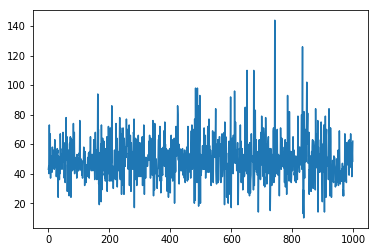

In [22]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [23]:
entropy(values)

tensor(9.9102)

In [24]:
distance_from_uniform(values)

tensor(0.8846)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [482]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result
  
def big_vector_to_str(x, thresh = 0.01):
  torch.set_printoptions(precision=2, sci_mode=False, threshold=5000)  
  result = "["
  for i, x_i in enumerate(x.data):
    if abs(x_i) > thresh:
      result += "{}: {:.2f}".format(i, x_i.item()) 
      result += ", " if (i < x.shape[0]-1) else ""
  result += "]"
  return result

def print_big_vector(x, thresh = 0.01):
  print(big_vector_to_str(x, thresh))

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [484]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [127]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [153]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [157]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)